In [1]:
!pip install lingam

In [2]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [3]:
map_columns = {
    'Unnamed: 0': 'index',
    'x0': 'Sex',
    'x1': 'Age',
    'x2': 'Credit',
    'x3': 'LoanDuration',
}

In [4]:
# Read Dataset German
x_train = pd.read_csv("data/algrec_german/X_train_short.csv").rename(columns=map_columns)
x_test = pd.read_csv("data/algrec_german/X_test_short.csv").rename(columns=map_columns)
y_train = pd.read_csv("data/algrec_german/y_train_short.csv").rename(columns={'Unnamed: 0': 'index'})
y_test = pd.read_csv("data/algrec_german/y_test_short.csv").rename(columns={'Unnamed: 0': 'index'})

x_train = x_train.set_index('index')
x_test = x_test.set_index('index')
y_train = y_train.set_index('index')
y_test = y_test.set_index('index')

dfx_full = pd.concat([x_train, x_test])
dfy_full = pd.concat([y_train, y_test])

In [9]:
zxc = pd.concat([x_train, y_train], axis = 1)
zxc.head()

,Sex,Age,Credit,LoanDuration,y
index,,,,,
674,1.0,41.0,2580.0,21.0,0.0
123,1.0,63.0,781.0,10.0,1.0
167,0.0,20.0,1577.0,11.0,1.0
258,0.0,23.0,3812.0,15.0,1.0
583,1.0,33.0,2384.0,36.0,0.0


In [10]:
x_train

,Sex,Age,Credit,LoanDuration
index,,,,
674,1.0,41.0,2580.0,21.0
123,1.0,63.0,781.0,10.0
167,0.0,20.0,1577.0,11.0
258,0.0,23.0,3812.0,15.0
583,1.0,33.0,2384.0,36.0
...,...,...,...,...
614,0.0,22.0,1808.0,18.0
224,1.0,30.0,4657.0,15.0
447,1.0,35.0,2576.0,7.0


In [100]:
model = RandomForestClassifier()  
model.fit(x_train, y_train)

index_samples = [747, 349, 646, 76, 890]

x_test_sample = x_test.loc[index_samples]
y_test_sample = y_test.loc[index_samples]


p = model.predict(x_test)

print(classification_report(y_test, p))

K = 10 #Number of counterfactual explanations to be obtained

explainerCSSE = CSSE(dfx_full, model, K = K, num_gen = 10)

              precision    recall  f1-score   support

         0.0       0.47      0.65      0.55        66
         1.0       0.61      0.43      0.50        84

    accuracy                           0.53       150
   macro avg       0.54      0.54      0.53       150
weighted avg       0.55      0.53      0.52       150



In [101]:
# model_lingam = lingam.DirectLiNGAM()

# result_lingam_bt = model_lingam.bootstrap(dfx_full, n_sampling=100)

# causal_effects = result_lingam_bt.get_total_causal_effects(min_causal_effect=0.01)

# df_causal_effects = pd.DataFrame(causal_effects)
# labels = [f'{i}' for i in dfx_full.columns]

# df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
# df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])

# causal_order = [labels[x] for x in model_lingam.causal_order_]

In [102]:
# causal_order

In [103]:
# df_causal_effects

In [104]:
# make_dot(model_lingam.adjacency_matrix_)

In [105]:
model_lingam = lingam.DirectLiNGAM()
model_lingam.fit(dfx_full)

In [106]:
labels = [f'{i}' for i in dfx_full.columns]
causal_order = [labels[x] for x in model_lingam.causal_order_]
causal_order

['Sex', 'LoanDuration', 'Credit', 'Age']

In [107]:
matrix_adj = model_lingam.adjacency_matrix_
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix_adj)):
    for j in range(len(matrix_adj[i])):
        if matrix_adj[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix_adj[i][j])

# Criando o DataFrame
df_causal_effects = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in dfx_full.columns]
df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])
df_causal_effects

,from,to,effect
0,Sex,Age,5.592995
1,LoanDuration,Credit,142.214200


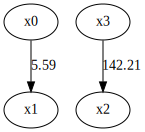

In [108]:
make_dot(model_lingam.adjacency_matrix_)

In [109]:
matrix_error = model_lingam.get_error_independence_p_values(dfx_full)
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix_error)):
    for j in range(i + 1, len(matrix_error[i])):
        if matrix_error[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix_error[i][j])

# Criando o DataFrame
df_error = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in dfx_full.columns]
df_error['from'] = df_error['from'].apply(lambda x : labels[x])
df_error['to'] = df_error['to'].apply(lambda x : labels[x])
df_error

,from,to,effect
0,Age,Sex,3.280976e-04
1,Credit,Sex,1.105868e-01
2,LoanDuration,Sex,3.242078e-01
3,Credit,Age,1.291857e-01
4,LoanDuration,Age,9.443619e-01
5,LoanDuration,Credit,1.834313e-41


In [110]:
matrix_error

array([[0.00000000e+00, 3.28097607e-04, 1.10586805e-01, 3.24207821e-01],
       [3.28097607e-04, 0.00000000e+00, 1.29185668e-01, 9.44361892e-01],
       [1.10586805e-01, 1.29185668e-01, 0.00000000e+00, 1.83431285e-41],
       [3.24207821e-01, 9.44361892e-01, 1.83431285e-41, 0.00000000e+00]])

In [111]:
def apply_causality(df):
    df_apply_causal = pd.DataFrame(columns = df.columns)
    original = df.iloc[0]
    df_apply_causal.loc[0] = original
    for index, df_row in df.iloc[1:].iterrows():
        causal_ind = df_row.copy()
        for column in causal_order:
            value_diff = causal_ind[column] - original[column]
            if value_diff != 0:
                tmp_effects = df_causal_effects[df_causal_effects['from'] == column]
                for index, row in tmp_effects.iterrows():
#                     prob = rnd.random()
#                     if row['probability'] <= prob:
                    tmp_error = df_error[df_error['from'].isin([column, row['to']]) | df_error['to'].isin([column, row['to']])]
                    error_value = tmp_error['effect'].iloc[0]
#                     print(f'error value = {error_value}')
                    causal_ind[row['to']] = causal_ind[row['to']] + (value_diff * row['effect']) + tmp_error['effect'].iloc[0]
        df_apply_causal.loc[len(df_apply_causal)] = causal_ind
    return df_apply_causal
    
def euclidean_distance(series1, series2):
    # Verificando se as séries têm o mesmo comprimento
    if len(series1) != len(series2):
        raise ValueError("As séries devem ter o mesmo comprimento.")
    
    # Calculando a diferença quadrática entre os elementos das séries
    squared_diff = (series1 - series2) ** 2
    
    # Calculando a soma das diferenças quadráticas
    sum_squared_diff = np.sum(squared_diff)
    
    # Calculando a raiz quadrada da soma
    euclidean_dist = np.sqrt(sum_squared_diff)
    
    return euclidean_dist

def get_contrafac_df_causal(solution_list_causal):
    lista_solution_causal = [[t.column for t in sublist] for sublist in solution_list_causal]

    # Inicializa uma lista para armazenar os resultados
    resultados = []

    # Loop sobre os valores na lista
    for lista_valores in lista_solution_causal:
        if len(lista_valores) > 1:
            for v1 in lista_valores:
                for v2 in lista_valores:
                    if v1 != v2:
                        # Cria uma condição para cada par de valores diferentes na lista
                        condicao = (df_causal_effects['to'].isin([v1, v2])) & (df_causal_effects['from'].isin([v1, v2]))
                        # Realiza a busca no DataFrame usando a condição e armazena os resultados
                        resultados.append(df_causal_effects[condicao])

    # Concatena os resultados em um único DataFrame
    if resultados:
        resultado_final = pd.concat(resultados)
        resultado_final = resultado_final.drop_duplicates()
    else:
        resultado_final = pd.DataFrame(columns = df_causal_effects.columns)
        
    return resultado_final

def analyse_contrafac(contrafac, df, original_ind):
    columns = [x.column for x in contrafac]
    condicao = (df['to'].isin(columns)) & (df['from'].isin(columns))
    ind = original_ind[columns]
    return [contrafac, df[condicao], ind]

def verificar_condicoes(row):
    if (row['from'] == 'mais' and row['to'] == 'mais' and row['effect'] > 0):
        return True
    elif row['from'] == 'menos' and row['to'] == 'menos' and row['effect'] > 0:
        return True
    elif row['from'] == 'mais' and row['to'] == 'menos' and row['effect'] < 0:
        return True
    elif row['from'] == 'menos' and row['to'] == 'mais' and row['effect'] < 0:
        return True
    else:
        return False

In [112]:
def get_causal_explain(X):
    original_ind = x_test.iloc[X].copy() #Original instance
    #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
    explainerCSSE.current_class = p[X] #Original instance class
    explainerCSSE.original_ind = original_ind

    ind_cur_class = explainerCSSE.getBadClass()

    #Gets the valid values range of each feature
    features_range = []
    features_range = explainerCSSE.getFeaturesRange()

    #The DataFrame df will have the current population
    df = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)

    #Generates the initial population with popinitial mutants        
    explainerCSSE.getPopInicial(df, features_range)
    df_causal = df.copy()
    dict_dfs = {}

    # for g in tqdm(range(explainerCSSE.num_gen), desc= "Processing..."):
    for g in tqdm(range(10), desc= "Processing..."):

        #To use on the parents of each generation
        parents = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)

        #Copy parents to the next generation
        parents = df_causal.copy()
        dict_dfs[g] = {}

        parents_causal = apply_causality(parents)
        dict_dfs[g]['causal_parents'] = parents_causal
        #df will contain the new population
        df_causal = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)
        evaluation_causal = []

        #Assessing generation counterfactuals
        explainerCSSE.fitness(dict_dfs[g]['causal_parents'], evaluation_causal, ind_cur_class)

        #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
        df_causal.loc[0] = original_ind.copy()

        #Copies to the next generation the per_elit best individuals
        explainerCSSE.elitism(evaluation_causal, df_causal, parents_causal)
        number_cross_repetitions = 0
        while len(df_causal) < explainerCSSE.pop_size + 1: #+1, as the 1st position is used to store the reference individual
            number_cross_repetitions_causal = explainerCSSE.crossover(df_causal, parents_causal, evaluation_causal, number_cross_repetitions)

            mutation_op = rnd.random()
            if mutation_op <= explainerCSSE.mutation_proba:
                explainerCSSE.mutation(df_causal, len(df_causal) - 1, features_range)


    evaluation = []
    evaluation_causal = []

    #Evaluating the latest generation
    explainerCSSE.fitness(df_causal, evaluation_causal, ind_cur_class)

    #Order the last generation by distance to the original instance     
    evaluation_causal.sort(key=lambda individual: individual.aval_norm) 

    #Getting the counterfactual CAUSAL set
    contrafactual_set_causal, solution_list_causal = explainerCSSE.getContrafactual(df_causal, evaluation_causal) 

    dict_dfs['contrafactual_set_causal'] = contrafactual_set_causal
    dict_dfs['solution_list_causal'] = solution_list_causal
    df_contrafac_causal = get_contrafac_df_causal(solution_list_causal)
    return [solution_list_causal, df_contrafac_causal, original_ind]

In [113]:
def run(original_row):
    response_list = get_causal_explain(original_row)
    list_analyse = []
    for contrafac_causal in response_list[0]:
        list_analyse.append(analyse_contrafac(contrafac_causal, response_list[1], response_list[2]))
    return list_analyse

In [114]:
%time
global_quant_changes = 0
global_quant_causal_changes = 0
global_quant_causal_rules = 0
global_quant_zeros_causal = 0
global_quant_full_causal = 0
global_quant_causal_contrafac = 0
global_quant_maioria_causal_satisfeita = 0
global_quant_contrafac_unico = 0

quant_original_instance = 10
for x in range(quant_original_instance):
    print(f"\nrun {x}")
    runs = run(x)
    for content in runs:
        controle = {}
        causal = content[0]
        df = content[1]
        ori = content[2]
        
        num_changes = len(causal)
        global_quant_changes += num_changes
        
        num_causal_rules = len(df)
        global_quant_causal_rules += num_causal_rules
        
        for attr in causal:
            key = attr.column
            if attr.value > ori[key]:
                controle[key] = 'mais'
            else:
                controle[key] = 'menos'

        df_temp = df.copy()
        df_temp['from'] = df['from'].map(controle)
        df_temp['to'] = df['to'].map(controle)
        df_temp['causal'] = df_temp.apply(verificar_condicoes, axis = 1)
        
        causal_finds = df_temp['causal'].sum()
        global_quant_causal_changes += causal_finds
        
        print(f'causal = \n{causal}\n')
        print(f'original = \n{ori}\n')
        print(f'df_temp = \n{display(df_temp)}\n')
        
        if len(df_temp) > 0:
            if causal_finds > 0:
                global_quant_causal_contrafac += 1
            else:
                print(f'nenhuma relaçao causal satisfeita')
                global_quant_zeros_causal += 1
#                 display(df_temp)
#                 print(f"original = {ori}")
#                 print(f"causal = {causal}")

            if causal_finds == num_causal_rules:
                global_quant_full_causal += 1
                if causal_finds > 2:
                    print(f'todas > 2 relaçoes causais satisfeitas')
#                     display(df_temp)
#                     print(f"original = {ori}")
#                     print(f"causal = {causal}")
                elif causal_finds == 1:
                    print(f'todas = 1 relaçoes causais satisfeitas')
            
            if causal_finds >= (len(df_temp)/2):
                global_quant_maioria_causal_satisfeita += 1
        else:
#             if len(causal) > 0:
            global_quant_contrafac_unico += 1
    
        print('---------------------------------------------------\n')
        

                
quant_contrafac = quant_original_instance*K

print()
print(f"quantas instancias contrafactuais encontradas = {quant_contrafac}")
print(f"quantidade de mudanças totais = {global_quant_changes}")

print(f"quantas instancias tiveram pelo menos uma relação causal satisfeita = {global_quant_causal_contrafac}/{quant_contrafac}")

print(f"quantas relações causais foram encontradas = {global_quant_causal_rules}")

print(f"quantas relações causais foram satisfeitas = {global_quant_causal_changes}/{global_quant_causal_rules}")

print(f"quantas instâncias não tiveram nenhuma relação causal satisfeita = {global_quant_zeros_causal}/{quant_contrafac}")
print(f"quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = {global_quant_full_causal}/{global_quant_causal_contrafac}")

print(f'quantas instancias causais teveram a maioria das relacoes causais satisfeitas = {global_quant_maioria_causal_satisfeita}/{quant_contrafac}')
print(f'quantas instancias tiveram um unico atributo modificado = {global_quant_contrafac_unico}/{quant_contrafac}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs

run 0


Processing...: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

causal = 
[('Credit', 1517.2968693271691)]

original = 
Credit    1274.0
Name: 747, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 39.01380620164016)]

original = 
Age    37.0
Name: 747, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.53), ('Age', 36.71)]

original = 
Sex     0.0
Age    37.0
Name: 747, dtype: float64



,from,to,effect,causal
0,mais,menos,5.592995,False


df_temp = 
None

nenhuma relaçao causal satisfeita
---------------------------------------------------


run 1


Processing...: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

causal = 
[('Credit', 1472.0678599418534)]

original = 
Credit    1136.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 26.798842995522268)]

original = 
Age    32.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 2


Processing...: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

causal = 
[('Credit', 2139.3765060732317)]

original = 
Credit    1264.0
Name: 979, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1798.1730121464634), ('LoanDuration', 12.6)]

original = 
Credit          1264.0
LoanDuration      15.0
Name: 979, dtype: float64



,from,to,effect,causal
1,menos,mais,142.2142,False


df_temp = 
None

nenhuma relaçao causal satisfeita
---------------------------------------------------

causal = 
[('Sex', 0.46), ('Age', 3.8607765909053753)]

original = 
Sex     1.0
Age    25.0
Name: 979, dtype: float64



,from,to,effect,causal
0,menos,menos,5.592995,True


df_temp = 
None

todas = 1 relaçoes causais satisfeitas
---------------------------------------------------


run 3


Processing...: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

causal = 
[('Credit', 1076.31)]

original = 
Credit    697.0
Name: 925, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 21.16)]

original = 
Age    46.0
Name: 925, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 29.278586235096373), ('Credit', 767.57)]

original = 
Age        46.0
Credit    697.0
Name: 925, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 4


Processing...: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

causal = 
[('Credit', 5026.17)]

original = 
Credit    7253.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 47.32)]

original = 
Age    35.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 40.36), ('Credit', 8339.627077136378)]

original = 
Age         35.0
Credit    7253.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 5


Processing...: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

causal = 
[('Credit', 2727.8261925933452)]

original = 
Credit    2442.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 48.1)]

original = 
Age    43.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 2617.120289966287), ('LoanDuration', 26.61)]

original = 
Credit          2442.0
LoanDuration      27.0
Name: 890, dtype: float64



,from,to,effect,causal
1,menos,mais,142.2142,False


df_temp = 
None

nenhuma relaçao causal satisfeita
---------------------------------------------------

causal = 
[('Age', 45.94), ('Credit', 2174.858477037338)]

original = 
Age         43.0
Credit    2442.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.51), ('Age', 46.18928203468742)]

original = 
Sex     1.0
Age    43.0
Name: 890, dtype: float64



,from,to,effect,causal
0,menos,mais,5.592995,False


df_temp = 
None

nenhuma relaçao causal satisfeita
---------------------------------------------------


run 6


Processing...: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

causal = 
[('Credit', 3688.5832668864155)]

original = 
Credit    4583.0
Name: 646, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 26.63170934873405)]

original = 
Age    32.0
Name: 646, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 34.65087571479709), ('Credit', 5242.984476221095)]

original = 
Age         32.0
Credit    4583.0
Name: 646, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.48), ('Age', 29.015912508679214)]

original = 
Sex     1.0
Age    32.0
Name: 646, dtype: float64



,from,to,effect,causal
0,menos,menos,5.592995,True


df_temp = 
None

todas = 1 relaçoes causais satisfeitas
---------------------------------------------------


run 7


Processing...: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

causal = 
[('Credit', 4775.71)]

original = 
Credit    719.0
Name: 443, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 34.15)]

original = 
Age    41.0
Name: 443, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 8


Processing...: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]

causal = 
[('Age', 35.37601872317066)]

original = 
Age    34.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 2945.29)]

original = 
Credit    3965.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('LoanDuration', 54.45)]

original = 
LoanDuration    42.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 4605.1850749838395), ('LoanDuration', 44.25)]

original = 
Credit          3965.0
LoanDuration      42.0
Name: 76, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

todas = 1 relaçoes causais satisfeitas
---------------------------------------------------


run 9


Processing...: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

causal = 
[('Credit', 2471.87)]

original = 
Credit    2613.0
Name: 225, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 25.87)]

original = 
Age    27.0
Name: 225, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


quantas instancias contrafactuais encontradas = 100
quantidade de mudanças totais = 42
quantas instancias tiveram pelo menos uma relação causal satisfeita = 3/100
quantas relações causais foram encontradas = 7
quantas relações causais foram satisfeitas = 3.0/7
quantas instâncias não tiveram nenhuma relação causal satisfeita = 4/100
quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = 3/3
quantas instancias causais teveram a maioria das relacoes causais satisfeitas = 3/100
quantas instancias tiveram um unico atributo modificado = 24/100


In [15]:
df_temp

,from,to,effect,probability,causal
6,mais,mais,26.367079,0.026,True
5,mais,mais,-0.122798,0.032,False
2,mais,mais,-0.043397,0.110,False
1,mais,mais,137.080334,0.634,True


In [20]:
x = pd.DataFrame(columns = ['to','effect','probability','causal'])
x

,to,effect,probability,causal


In [21]:
display(x)

,to,effect,probability,causal


In [24]:
if x is None:
    print('t')